In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import numpy as np

In [2]:
candidates = pd.read_csv('../data/candidates_clean.csv', dtype = {'district': 'str'}) # refactor to explicitly set district as string

candidates.head()

,candidate_name,party,incumbent,winner,perc_vote,money_raised,money_spent,state_name,district,state_dist,perc_vote_max,winner_bool
0,Jerry Carl,R,0,1,64.9,1971321,1859349,AL,01,AL01,64.9,1
1,James Averhart,D,0,0,35.0,80095,78973,AL,01,AL01,64.9,0
2,Barry Moore,R,0,1,65.3,650807,669368,AL,02,AL02,65.3,1
3,Phyllis Harvey-Hall,D,0,0,34.6,56050,55988,AL,02,AL02,65.3,0
4,Mike D Rogers,R,1,1,67.5,1193111,1218564,AL,03,AL03,67.5,1


In [3]:
candidates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   candidate_name  883 non-null    object 
 1   party           883 non-null    object 
 2   incumbent       883 non-null    int64  
 3   winner          883 non-null    int64  
 4   perc_vote       883 non-null    float64
 5   money_raised    883 non-null    int64  
 6   money_spent     883 non-null    int64  
 7   state_name      883 non-null    object 
 8   district        883 non-null    object 
 9   state_dist      883 non-null    object 
 10  perc_vote_max   883 non-null    float64
 11  winner_bool     883 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 82.9+ KB


In [4]:
candidates['party'].value_counts()

D    419
R    382
I     46
L     21
3     15
Name: party, dtype: int64

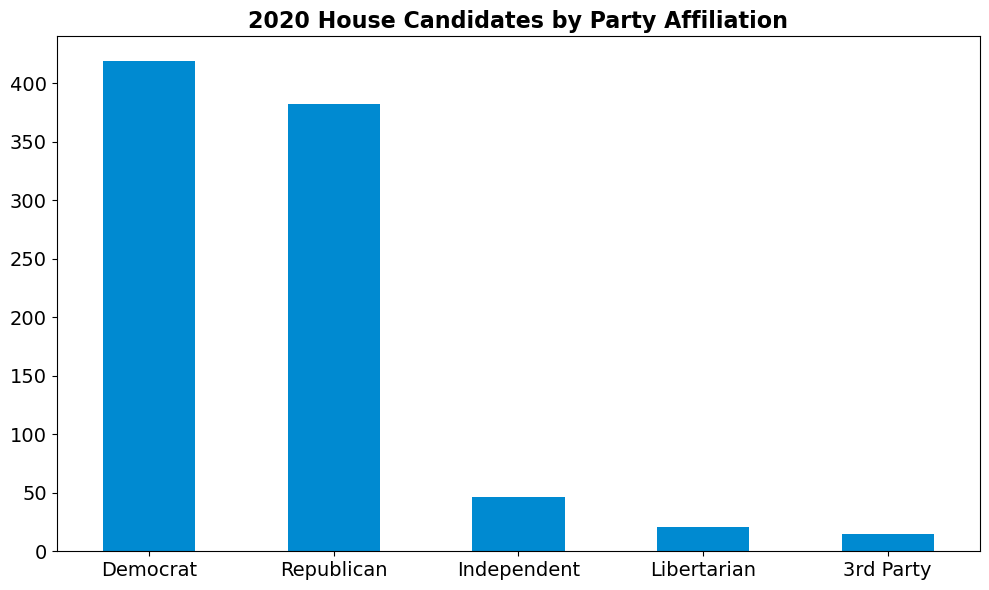

In [5]:
plt.figure(figsize = (10, 6))
fontsize = 14
x_labels = ['Democrat', 'Republican', 'Independent', 'Libertarian', '3rd Party']
x_ticks = [0, 1, 2, 3, 4]
color = '#008ad1'

candidates['party'].value_counts().plot(kind = 'bar', color = color)
plt.xticks(rotation = 0, labels = x_labels, ticks = x_ticks, fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.title('2020 House Candidates by Party Affiliation', fontsize = fontsize + 2, weight = 'bold')
plt.tight_layout();
plt.savefig('../assets/party_affiliation.png', dpi = 150);

In [6]:
candidates.loc[(candidates['party'].isin(['I', 'L', '3'])) & (candidates['winner'] == 1)]

# no independent or 3rd party candidate won a race

,candidate_name,party,incumbent,winner,perc_vote,money_raised,money_spent,state_name,district,state_dist,perc_vote_max,winner_bool


In [7]:
candidates.loc[candidates['winner'] != candidates['winner_bool']]

# confirmation that 2 districts didn't have a winner marked and that the added column is behaving as expected

,candidate_name,party,incumbent,winner,perc_vote,money_raised,money_spent,state_name,district,state_dist,perc_vote_max,winner_bool
264,Ed Case,D,1,0,64.7,508249,472569,HI,01,HI01,64.7,1
664,Scott Perry,R,1,0,53.4,3956481,3839197,PA,10,PA10,53.4,1


In [8]:
candidates['party'].loc[candidates['winner'] == 1].value_counts()

D    221
R    210
Name: party, dtype: int64

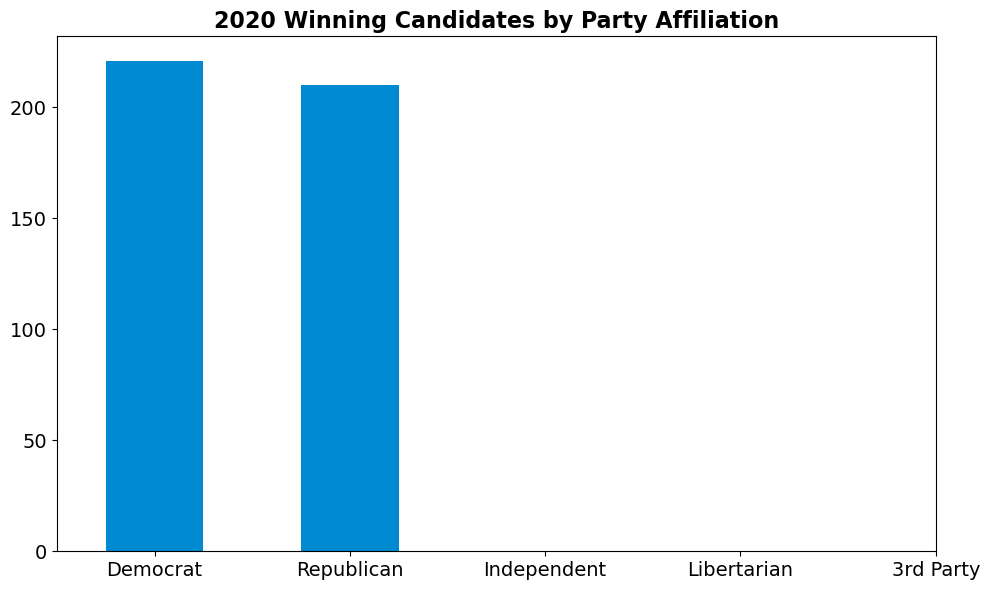

In [9]:
plt.figure(figsize = (10, 6))
fontsize = 14
x_labels = ['Democrat', 'Republican', 'Independent', 'Libertarian', '3rd Party']
x_ticks = [0, 1, 2, 3, 4]
color = '#008ad1'
candidates['party'].loc[candidates['winner'] == 1].value_counts().plot(kind = 'bar', color = color)
plt.xticks(rotation = 0, labels = x_labels, ticks = x_ticks, fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.title('2020 Winning Candidates by Party Affiliation', fontsize = fontsize + 2, weight = 'bold')
plt.tight_layout();
plt.savefig('../assets/party_affiliation_winners.png', dpi = 150);

### how many races didn't have an incumbant running? How does that correlate with number of candidates in the race?

### How often does the candidate who raised more money win a race?

Partition by state and district, sort by money_raised, qualify row_num = 1 (to only have the person from each race who raised the most money). Chart value_counts of winner column.

In [10]:
# new column with max raised in each district race
candidates['max_raised'] = candidates.groupby(['state_name', 'district'])['money_raised'].transform('max')

In [11]:
raised_winner = candidates.loc[candidates['money_raised'] == candidates['max_raised']]

In [12]:
raised_winner['winner'].value_counts()

1    384
0     49
Name: winner, dtype: int64

<Figure size 1000x600 with 0 Axes>

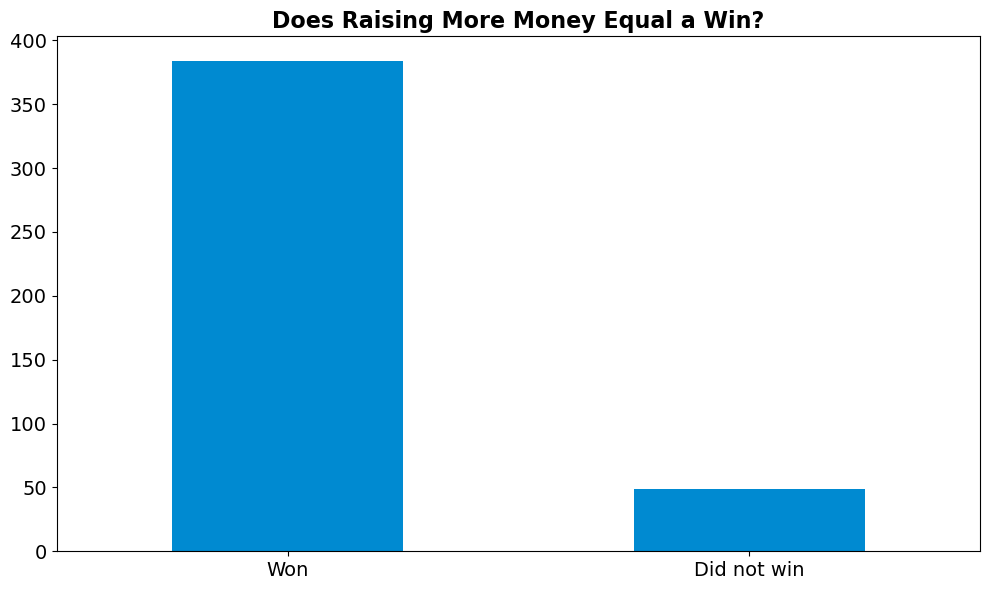

In [13]:
plt.figure(figsize = (10, 6))
fontsize = 14
x_labels = ['Won', 'Did not win']
x_ticks = [0, 1]
color = '#008ad1'

plt.figure(figsize = (10,6))
raised_winner['winner'].value_counts().plot(kind = 'bar',stacked = True, color = color)
plt.xticks(rotation = 0, labels = x_labels, ticks = x_ticks, fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.title('Does Raising More Money Equal a Win?', fontsize = fontsize + 2, weight = 'bold')
plt.tight_layout();
plt.savefig('../assets/money_raised_winners.png', dpi = 150);

#### How often does the candidate who spent more money win a race?

Same strategy as previous question.

<Figure size 1000x600 with 0 Axes>

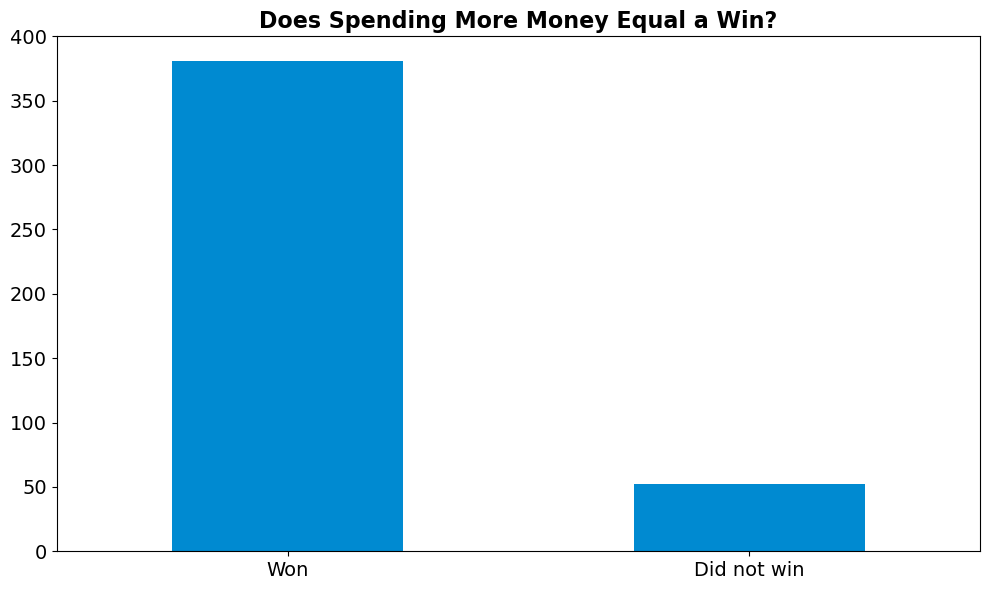

In [14]:
# new column with max spent in each district race
candidates['max_spent'] = candidates.groupby(['state_name', 'district'])['money_spent'].transform('max')

spent_winner = candidates.loc[candidates['money_spent'] == candidates['max_spent']]

plt.figure(figsize = (10, 6))
fontsize = 14
x_labels = ['Won', 'Did not win']
x_ticks = [0, 1]
color = '#008ad1'

plt.figure(figsize = (10,6))
spent_winner['winner'].value_counts().plot(kind = 'bar',stacked = True, color = color)
plt.xticks(rotation = 0, labels = x_labels, ticks = x_ticks, fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.title('Does Spending More Money Equal a Win?', fontsize = fontsize + 2, weight = 'bold')
plt.tight_layout();
plt.savefig('../assets/money_spent_winners.png', dpi = 150);

# are the ones who raised and spent the most money mostly synonymous? Seems likely

In [15]:
spent_winner['winner'].value_counts()

1    381
0     52
Name: winner, dtype: int64

#### Does the difference between either money raised or money spent seem to influence the likelihood of a candidate winning a race?

strategy: filter to top 2 candidates in each race, new column calculating the total spent in the race, and a column calculating the difference between winner and 2nd place in $, plus % calculation


In [16]:
# filter to max 2 from each race

candidates_top2 = candidates.iloc[candidates.reset_index().groupby('state_dist')['perc_vote'].nlargest(2).index.levels[1]] # refactor to account for the concat column I added above (easier, not strictly necessary)

candidates_top2.head()

,candidate_name,party,incumbent,winner,perc_vote,money_raised,money_spent,state_name,district,state_dist,perc_vote_max,winner_bool,max_raised,max_spent
0,Jerry Carl,R,0,1,64.9,1971321,1859349,AL,01,AL01,64.9,1,1971321,1859349
1,James Averhart,D,0,0,35.0,80095,78973,AL,01,AL01,64.9,0,1971321,1859349
2,Barry Moore,R,0,1,65.3,650807,669368,AL,02,AL02,65.3,1,650807,669368
3,Phyllis Harvey-Hall,D,0,0,34.6,56050,55988,AL,02,AL02,65.3,0,650807,669368
4,Mike D Rogers,R,1,1,67.5,1193111,1218564,AL,03,AL03,67.5,1,1193111,1218564


In [17]:
candidates_top2.shape

# full candidates df has 892 rows, seems like not too many races have more than 2 candidates (or many districts are uncontested)

(806, 14)

side question - how many races are uncontested? Even in Alabama with 7 districts, it looks like 4 of them were uncontested.

In [18]:
(candidates_top2['state_dist'].value_counts() == 1).sum()

# 60 seats uncontested, see what the guys think about including this kind of information and make a graph

60

In [19]:
# columns for total raised and spent by top two candidates in each race
candidates_top2['total_raised'] = candidates_top2.groupby('state_dist')['money_raised'].transform('sum')
candidates_top2['total_spent'] = candidates_top2.groupby('state_dist')['money_spent'].transform('sum')

# column for % of total (not sure I need the $ difference, add later if needed)
candidates_top2['perc_raised'] = candidates_top2['money_raised'] / candidates_top2['total_raised'] * 100
candidates_top2['perc_spent'] = candidates_top2['money_spent'] / candidates_top2['total_spent'] * 100

candidates_top2.head()

/var/folders/xm/vmtk5pms0jzb2kmtm00lwtn80000gn/T/ipykernel_59456/3465422768.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates_top2['total_raised'] = candidates_top2.groupby('state_dist')['money_raised'].transform('sum')
/var/folders/xm/vmtk5pms0jzb2kmtm00lwtn80000gn/T/ipykernel_59456/3465422768.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates_top2['total_spent'] = candidates_top2.groupby('state_dist')['money_spent'].transform('sum')
/var/folders/xm/vmtk5pms0jzb2kmtm00lwtn80000gn/T

,candidate_name,party,incumbent,winner,perc_vote,money_raised,money_spent,state_name,district,state_dist,perc_vote_max,winner_bool,max_raised,max_spent,total_raised,total_spent,perc_raised,perc_spent
0,Jerry Carl,R,0,1,64.9,1971321,1859349,AL,01,AL01,64.9,1,1971321,1859349,2051416,1938322,96.095624,95.925703
1,James Averhart,D,0,0,35.0,80095,78973,AL,01,AL01,64.9,0,1971321,1859349,2051416,1938322,3.904376,4.074297
2,Barry Moore,R,0,1,65.3,650807,669368,AL,02,AL02,65.3,1,650807,669368,706857,725356,92.070532,92.281307
3,Phyllis Harvey-Hall,D,0,0,34.6,56050,55988,AL,02,AL02,65.3,0,650807,669368,706857,725356,7.929468,7.718693
4,Mike D Rogers,R,1,1,67.5,1193111,1218564,AL,03,AL03,67.5,1,1193111,1218564,1243384,1259535,95.956760,96.747133


In [20]:
# logistic regression for money raised

formula = 'winner_bool ~ money_raised'

raised_model = smf.logit(formula = formula, data = candidates_top2).fit()

raised_model.summary()

Optimization terminated successfully.
         Current function value: 0.649888
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            winner_bool   No. Observations:                  806
Model:                          Logit   Df Residuals:                      804
Method:                           MLE   Df Model:                            1
Date:                Tue, 24 Oct 2023   Pseudo R-squ.:                 0.05864
Time:                        05:22:06   Log-Likelihood:                -523.81
converged:                       True   LL-Null:                       -556.44
Covariance Type:            nonrobust   LLR p-value:                 6.555e-16
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.3804      0.101     -3.753      0.000      -0.579      -0.182
money_raised  3.003e-07    4.5e-08      6.666      0.000    2.12e-07    3.89e-07
================================================================================
"""

In [21]:
# logistic regression for money spent

formula = 'winner_bool ~ money_spent'

spent_model = smf.logit(formula = formula, data = candidates_top2).fit()

spent_model.summary()

Optimization terminated successfully.
         Current function value: 0.663216
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            winner_bool   No. Observations:                  806
Model:                          Logit   Df Residuals:                      804
Method:                           MLE   Df Model:                            1
Date:                Tue, 24 Oct 2023   Pseudo R-squ.:                 0.03934
Time:                        05:22:06   Log-Likelihood:                -534.55
converged:                       True   LL-Null:                       -556.44
Covariance Type:            nonrobust   LLR p-value:                 3.679e-11
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.2531      0.097     -2.619      0.009      -0.443      -0.064
money_spent  2.414e-07   4.27e-08      5.649      0.000    1.58e-07    3.25e-07
===============================================================================
"""

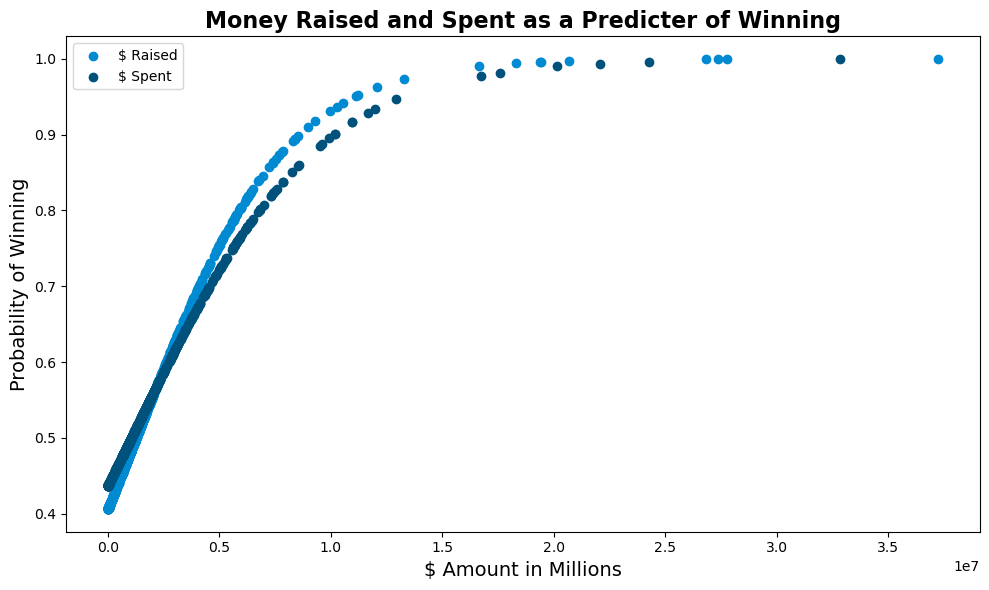

In [22]:
# plot the regressions

plt.figure(figsize = (10, 6))
fontsize = 14
color_1 = '#008ad1'
color_2 = '#00517cff'

x_raised = candidates_top2['money_raised']
y_raised = 1/(1 + (np.exp(-raised_model.params[0] - (raised_model.params[1] * x_raised))))
plt.scatter(x_raised, y_raised, c = color_1, label = '$ Raised')

x_spent = candidates_top2['money_spent']
y_spent = 1/(1 + (np.exp(-spent_model.params[0] - (spent_model.params[1] * x_spent))))
plt.scatter(x_spent, y_spent, c = color_2, label = '$ Spent')

plt.xlabel('$ Amount in Millions', fontsize = fontsize)
plt.ylabel('Probability of Winning', fontsize = fontsize)
plt.title('Money Raised and Spent as a Predicter of Winning', fontsize = fontsize + 2, weight = 'bold')
plt.legend()

plt.tight_layout()
plt.savefig('../assets/raised_spent_prediction.png', dpi = 150);

Calculate the difference in money between winner and runner-up as a predictor of winning.

Do I need to remove un-contested races? I think I do - look at them separately.

In [25]:
# top_2 df with uncontested races removed (also create df with just those races)

contested_top2 = candidates_top2[candidates_top2.groupby('state_dist')['state_dist'].transform('size') > 1]
uncontested = candidates_top2[candidates_top2.groupby('state_dist')['state_dist'].transform('size') == 1]

print(contested_top2.shape)
print(uncontested.shape)

(746, 18)
(60, 18)


In [29]:
contested_top2['raised_diff'] = contested_top2['total_raised'] - contested_top2['money_raised']

/var/folders/xm/vmtk5pms0jzb2kmtm00lwtn80000gn/T/ipykernel_59456/2601890816.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contested_top2['raised_diff'] = contested_top2['total_raised'] - contested_top2['money_raised']


In [32]:
contested_winner = contested_top2.loc[contested_top2['winner_bool'] == 1]

contested_winner.shape

(373, 19)

In [34]:
# logistic regression for difference between money raised, top 2 candidates (in contested races)

formula = 'winner_bool ~ raised_diff'

raised_diff_model = smf.logit(formula = formula, data = contested_top2).fit()

raised_diff_model.summary()

Optimization terminated successfully.
         Current function value: 0.648366
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            winner_bool   No. Observations:                  746
Model:                          Logit   Df Residuals:                      744
Method:                           MLE   Df Model:                            1
Date:                Tue, 24 Oct 2023   Pseudo R-squ.:                 0.06461
Time:                        05:48:42   Log-Likelihood:                -483.68
converged:                       True   LL-Null:                       -517.09
Covariance Type:            nonrobust   LLR p-value:                 2.984e-16
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.5465      0.105      5.217      0.000       0.341       0.752
raised_diff -3.034e-07   4.47e-08     -6.790      0.000   -3.91e-07   -2.16e-07
===============================================================================
"""

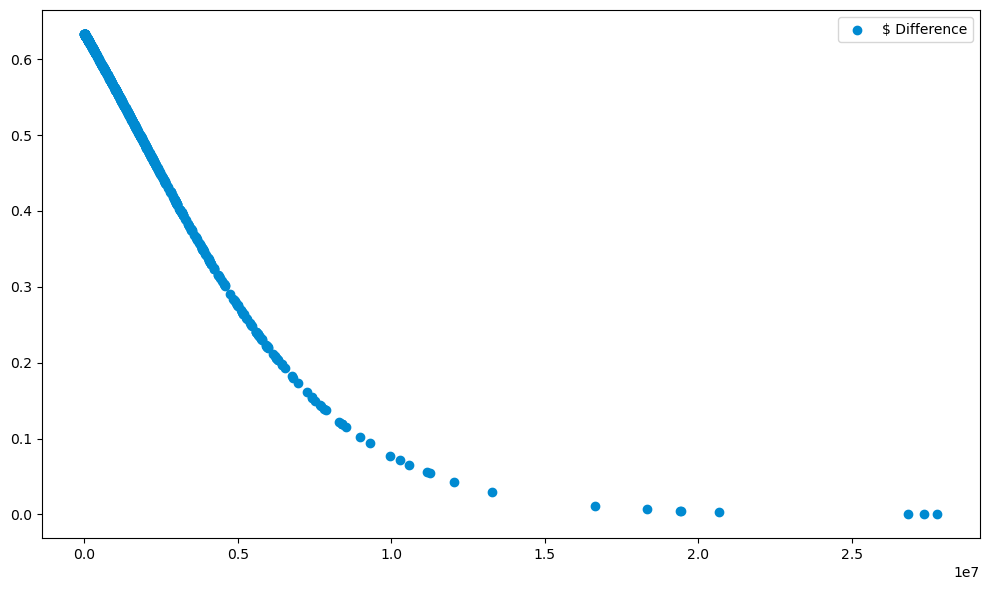

In [31]:
plt.figure(figsize = (10, 6))
fontsize = 14
color_1 = '#008ad1'
color_2 = '#00517cff'

x_diff = contested_top2['raised_diff']
y_diff = 1/(1 + (np.exp(-raised_diff_model.params[0] - (raised_diff_model.params[1] * x_diff))))
plt.scatter(x_diff, y_diff, c = color_1, label = '$ Difference')

# plt.xlabel('$ Amount in Millions', fontsize = fontsize)
# plt.ylabel('Probability of Winning', fontsize = fontsize)
# plt.title('Does Outraising Your Opponent Matter?', fontsize = fontsize + 2, weight = 'bold')
plt.legend()

plt.tight_layout()
# plt.savefig('../assets/raised_diff_prediction.png', dpi = 150);

According to the raised_diff model, the more you outraise your opponent the less well you do? That seems counter-intuitive. Don't present this without doing further confirmation work.

### How often does the incumbent win the race?

First, filter out races with no incumbent then calculate - value_counts on winner_bool where incumbent = 1